In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

    Author(s): Daniel Tweneboah Anyimadu, Taofik Ahmed Suleiman

# **CADx PROJECT: SKIN LESION CLASSIFICATION CHALLENGE USING DEEP LEARNING APPROACH**
    
- A deep learning (DL) approach is employed to address both two-class and three-class problems, improving classification accuracy despite huge class imbalances and lesion variations.

- **NB:** This code is for the three (3) class problem: mel, bcc, scc.

# IMPORT LIBRARIES (MODULES)

In [1]:
# Libraries for exploratory data analysis (EDA)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2 as cv
from glob import glob
from PIL import Image
import random
from tqdm import tqdm
from sklearn.utils import shuffle

# Libraries for data preprocessing
from sklearn.utils import resample
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Libraries for feature extraction/classification using deep learning
import keras
from keras.models import Sequential
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv2D, Dropout, Flatten, Dense, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.model_selection import KFold
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121

# Libraries for evaluation metrics 
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score, roc_curve, confusion_matrix, cohen_kappa_score

# Filter Warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# (A): EXPLORATORY DATA ANALYSIS

**Handling dataset:**

*- On Training*

In [2]:
#  Define file path
tr_dir_path = "/kaggle/input/multi-classification-bcc-mel-scc/Challenge_2/train" # Set path to train folder directory
tr_mel = os.path.join(tr_dir_path, "mel")                                        # Set path to tr_mel folder directory
tr_bcc = os.path.join(tr_dir_path, "bcc")                                        # Set path to tr_bcc folder directory
tr_scc = os.path.join(tr_dir_path, "scc")                                        # Set path to tr_scc folder directory

In [3]:
# mel:0, bcc:1, scc:2
# Initialize lists to store data
tr_img_names = []; tr_img_file = []; tr_gtruth_names = []; tr_gtruth = []

# For mel images (groundtruth = 0)
for mel_img in tqdm(os.listdir(tr_mel), desc = "mel"):
    tr_img_names.append(mel_img)
    tr_img_file.append(os.path.join(tr_mel, mel_img))
    tr_gtruth_names.append("mel")
    tr_gtruth.append(0)

# For bcc images (groundtruth = 1)
for bcc_img in tqdm(os.listdir(tr_bcc), desc = "bcc"):
    tr_img_names.append(bcc_img)
    tr_img_file.append(os.path.join(tr_bcc, bcc_img))
    tr_gtruth_names.append("bcc")
    tr_gtruth.append(1)
       
# For scc images (groundtruth = 2)
for scc_img in tqdm(os.listdir(tr_scc), desc = "scc"):
    tr_img_names.append(scc_img)
    tr_img_file.append(os.path.join(tr_scc, scc_img))
    tr_gtruth_names.append("scc")
    tr_gtruth.append(2)

scc: 100%|██████████| 376/376 [00:00<00:00, 222874.27it/s]


In [4]:
# Create a dataframe
tr_data = {"tr_img_names":tr_img_names, "tr_img_file":tr_img_file, "tr_gtruth_name":tr_gtruth_names, "tr_gtruth":tr_gtruth}; tr_img_names.sort()
tr_df = pd.DataFrame(tr_data)
tr_df.head()

,tr_img_names,tr_img_file,tr_gtruth_name,tr_gtruth
0,bcc00001.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
1,bcc00002.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
2,bcc00003.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
3,bcc00004.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
4,bcc00005.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0


    Visualization of training data

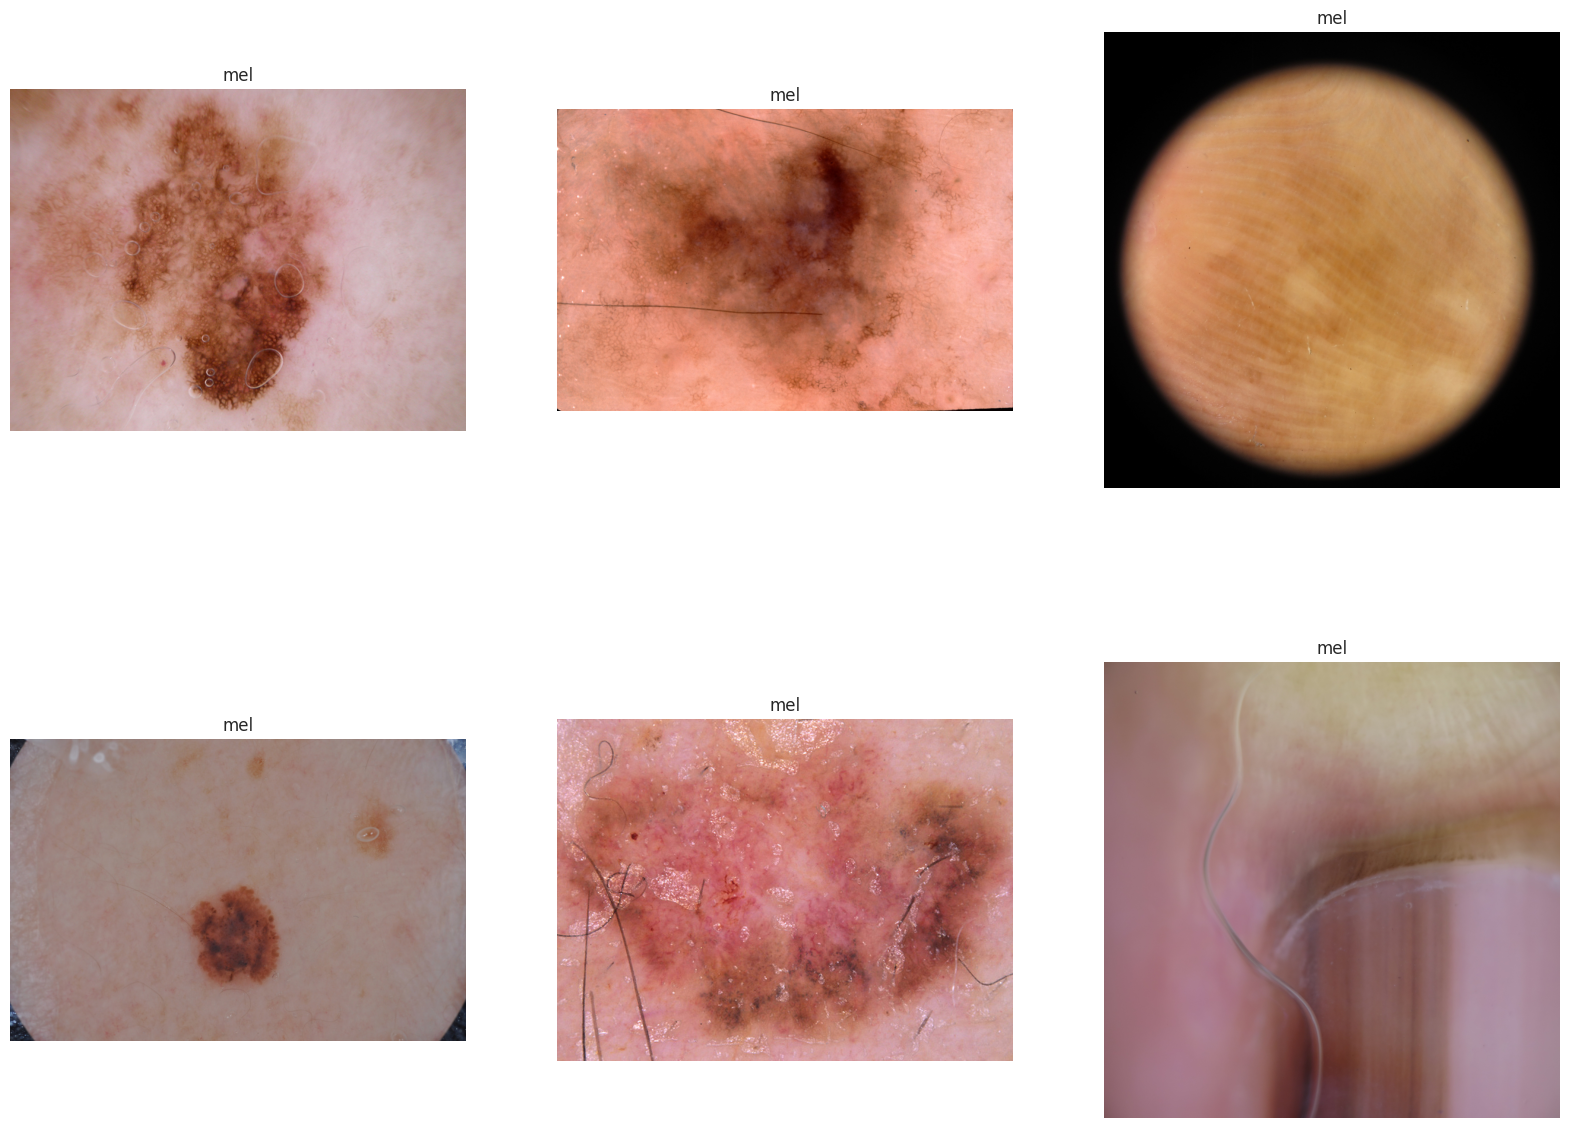

In [5]:
sns.set_style("white")
plt.figure(figsize = [20,15])

for i, (img_path, gnd_truth) in enumerate(zip(tr_df["tr_img_file"][:6], tr_df["tr_gtruth"][:6])): 
    if gnd_truth == 0:
        title = "mel"
    elif gnd_truth == 1: 
        title = "bcc" 
    else:
        title = "scc"
    img_data = cv.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(cv.cvtColor(img_data, cv.COLOR_BGR2RGB))
    plt.axis("off"); plt.title(title)
    
plt.show()

*- On Validation Dataset*

In [6]:
#  Define file path
val_dir_path = "/kaggle/input/multi-classification-bcc-mel-scc/Challenge_2/val"
val_mel = os.path.join(val_dir_path, "mel")
val_bcc = os.path.join(val_dir_path, "bcc")
val_scc = os.path.join(val_dir_path, "scc")

# Initialize lists to store data
val_img_name = []; val_img_file = []; val_gtruth_names = []; val_gtruth = []
for mel_img in tqdm(os.listdir(val_mel), desc = "mel"):
    val_img_name.append(mel_img)
    val_img_file.append(os.path.join(val_mel, mel_img))
    val_gtruth_names.append("mel")
    val_gtruth.append(0)

for bcc_img in tqdm(os.listdir(val_bcc), desc = "bcc"):
    val_img_name.append(bcc_img)
    val_img_file.append(os.path.join(val_bcc, bcc_img))
    val_gtruth_names.append("bcc")
    val_gtruth.append(1)
    
for scc_img in tqdm(os.listdir(val_scc), desc = "scc"):
    val_img_name.append(scc_img)
    val_img_file.append(os.path.join(val_scc, scc_img))
    val_gtruth_names.append("scc")
    val_gtruth.append(2)

# Create a dataframe
val_data = {"val_img_name":val_img_name, "val_img_file":val_img_file, "val_gtruth_name":val_gtruth_names, "val_gtruth":val_gtruth}; val_img_name.sort()
val_df = pd.DataFrame(val_data)
val_df.head()

scc: 100%|██████████| 94/94 [00:00<00:00, 184321.91it/s]


,val_img_name,val_img_file,val_gtruth_name,val_gtruth
0,bcc01994.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
1,bcc01995.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
2,bcc01996.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
3,bcc01997.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
4,bcc01998.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0


# (B): DATA PREPROCESSING

    Resampling (Upsampling & Downsampling) Techniques

In [7]:
mel_data = tr_df[tr_df["tr_gtruth"] == 0]
bcc_data = tr_df[tr_df["tr_gtruth"] == 1]
scc_data = tr_df[tr_df["tr_gtruth"] == 2]

# Given class distribution
mel_cases = 2713; bcc_cases = 1993; scc_cases = 376

# Upsample "" and downsample ""
mel_downsampled = resample(mel_data, replace = False, n_samples = 2700, random_state = 42) # 2500, 2000, Without replacement
bcc_upsampled = resample(bcc_data, replace = True, n_samples = 2000, random_state = 42)    # 2000, 2000, With replacement
scc_upsampled = resample(scc_data, replace = True, n_samples = 1500, random_state = 42)    # 1000, 2000, With replacement

# Shuffle resampled data to avoid any learning bias
resampled_data = pd.concat([mel_downsampled, bcc_upsampled, scc_upsampled])
resampled_data = resampled_data.sample(frac = 1, random_state = 42)

In [8]:
resampled_data.head()

,tr_img_names,tr_img_file,tr_gtruth_name,tr_gtruth
5022,scc00317.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,scc,2
103,bcc00104.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
2450,mel00458.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0
4795,scc00090.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,scc,2
1374,bcc01375.jpg,/kaggle/input/multi-classification-bcc-mel-scc...,mel,0


**Data generation**

    Split the "resampled_df" class-wise to maintain class distribution. Training = first 80%, Fake_Test = second 20%

In [9]:
# Create StratifiedShuffleSplit object for class-wise splitting
sss = StratifiedShuffleSplit(n_splits = 1, test_size = 0.2, random_state = 42)

# Get the indices for splitting
train_indices, ftest_indices = next(sss.split(resampled_data["tr_img_file"], resampled_data["tr_gtruth_name"]))

# Create dataframes for training and fake_test
train_df_split = resampled_data.iloc[train_indices]
ftest_df_split = resampled_data.iloc[ftest_indices]

**Data augmentation**

In [10]:
# Data preprocessing (real-time augmentation) for 
# -----: (1) training
train_datagen = ImageDataGenerator(rescale = 1./255, zoom_range = 0.2, horizontal_flip = True, vertical_flip = True) # shear_range = 0.2
# -----: (2) fake_test
ftest_datagen = ImageDataGenerator(rescale = 1./255)

batch_size = 32 # batch size
# Flow training images in batches using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(dataframe = train_df_split, x_col = "tr_img_file", y_col = "tr_gtruth_name",
                                                    target_size = (224, 224), batch_size = batch_size, class_mode = "categorical")      

# Flow validation images in batches using ftest_datagen generator
ftest_generator = ftest_datagen.flow_from_dataframe(dataframe = ftest_df_split, x_col = "tr_img_file", y_col = "tr_gtruth_name",
                                                target_size = (224, 224), batch_size = batch_size, class_mode = "categorical")

Found 4960 validated image filenames belonging to 3 classes.
Found 1240 validated image filenames belonging to 3 classes.


**Compute class weight for unbalanced dataset**

In [11]:
from sklearn.utils.class_weight import compute_class_weight
class_labels = np.unique(train_df_split["tr_gtruth_name"])
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=train_df_split["tr_gtruth_name"])
class_weights_dict = dict(zip(range(len(class_labels)), class_weights))

**-----: Data Preprocessing (Augmentation) On Validation Data**

In [12]:
val_datagen = ImageDataGenerator(rescale = 1./255)

# Evaluate the model on the validation set
val_generator = val_datagen.flow_from_dataframe(dataframe = val_df, x_col = "val_img_file", y_col = "val_gtruth_name",
                                                target_size = (224, 224), batch_size = batch_size, class_mode = "categorical", shuffle = False)

Found 1270 validated image filenames belonging to 3 classes.


# (C): FEATURE EXTRACTION AND CLASSIFICATION

**Leveraging DL models for feature extraction and classification:**

    - Pre-trained model ()

# **- Pre-trained model (DenseNet121)**

In [12]:
# Load pre-trained DenseNet121 model with weights trained on ImageNet data
DN_model = DenseNet121(weights = "imagenet", include_top = False, input_shape = (224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in DN_model.layers:
    layer.trainable = False

model_dn = Sequential()
model_dn.add(DN_model)
model_dn.add(Flatten())
model_dn.add(Dense(128, activation = "relu"))
model_dn.add(Dropout(0.2))
model_dn.add(Dense(3, activation = "softmax"))

# Compile the model
model_dn.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.0001), metrics = ["accuracy"])

# Display the model architecture
model_dn.summary()

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 128)               6422656   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 13460547 (51.35 MB)
Trainable params: 6423043 (24.50 MB)
Non-trainable params: 7037504 (26.85 MB)
___________

    Callbacks

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn_mc.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [14]:
# Train the model
history_densenet = model_dn.fit(train_generator, epochs = 20, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/20
155/155 [==============================] - ETA: 0s - loss: 1.3014 - accuracy: 0.5585
Epoch 1: val_accuracy improved from -inf to 0.69516, saving model to best_model_dn_mc.hdf5
155/155 [==============================] - 162s 974ms/step - loss: 1.3014 - accuracy: 0.5585 - val_loss: 0.7490 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 2/20
155/155 [==============================] - ETA: 0s - loss: 0.7762 - accuracy: 0.6556
Epoch 2: val_accuracy improved from 0.69516 to 0.74032, saving model to best_model_dn_mc.hdf5
155/155 [==============================] - 111s 713ms/step - loss: 0.7762 - accuracy: 0.6556 - val_loss: 0.6484 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 3/20
155/155 [==============================] - ETA: 0s - loss: 0.7064 - accuracy: 0.6903
Epoch 3: val_accuracy did not improve from 0.74032
155/155 [==============================] - 110s 707ms/step - loss: 0.7064 - accuracy: 0.6903 - val_loss: 0.6728 - val_accuracy: 0.7129 - lr: 0.0010
Epoch 4/20
155/155 [============

In [15]:
# # Save the model weights
# model_dn.save_weights('model_dn_weights_mc.h5')
# print("Model has been saved.")

# Load the saved weights
model_dn.load_weights('/kaggle/working/best_model_dn_mc.hdf5')

39/39 [==============================] - 13s 328ms/step - loss: 0.4308 - accuracy: 0.8298
Ftest Loss: 0.43084678053855896, Ftest Accuracy: 0.8298386931419373


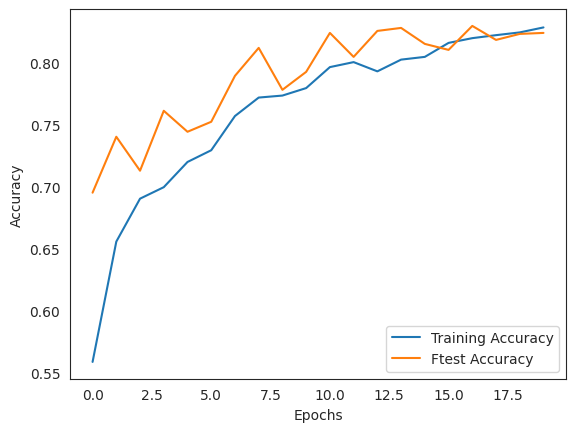

In [16]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_dn.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

In [22]:
# Evaluate the model on the validation set
val_loss, val_acc = model_dn.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predict class probabilities for the validation set
val_pred_probs = model_dn.predict(val_generator)
# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_pred_probs, axis=1)
# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- DenseNet EVALUATION METRICS -----\n")
accuracy_densenet = accuracy_score(val_true_labels, val_pred_labels); print(f"Accuracy: {accuracy_densenet}")
precision_densenet = precision_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Precision: {precision_densenet}")
recall_densenet = recall_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Recall: {recall_densenet}")
f1_densenet = f1_score(val_true_labels, val_pred_labels, average='weighted'); print(f"F1 Score: {f1_densenet}")
bma_densenet= balanced_accuracy_score(val_true_labels, val_pred_labels); print(f"Balanced Accuracy: {bma_densenet}")
kappa_densenet = cohen_kappa_score(val_true_labels, val_pred_labels); print(f"Cohen's Kappa: {kappa_densenet}")

40/40 [==============================] - 14s 337ms/step - loss: 0.5634 - accuracy: 0.7819
Validation Loss: 0.5634386539459229, Validation Accuracy: 0.7818897366523743
40/40 [==============================] - 13s 323ms/step

----- DenseNet EVALUATION METRICS -----

Accuracy: 0.7818897637795276
Precision: 0.814083478760851
Recall: 0.7818897637795276
F1 Score: 0.7947121163655627
Balanced Accuracy: 0.7036187176371337
Cohen's Kappa: 0.6224829693985741


# **- Pre-trained model (DenseNet201)**

Reference: https://github.com/hoang-ho/Skin_Lesions_Classification_DCNNs/blob/master/Fine_Tuning_DenseNet.ipynb

In [ ]:
from keras.applications.densenet import DenseNet201
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model

# Remove the top layers of the pre-trained DenseNet201 model
DN_model201 = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in DN_model201.layers:
    layer.trainable = False

# Add your own classification layers on top of the base model
x = GlobalAveragePooling2D()(DN_model201.output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)

# Create a new model with the modified architecture
model_dn201 = Model(inputs=DN_model201.input, outputs=x)

# Compile the model with an appropriate optimizer, loss, and metrics
model_dn201.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model architecture
model_dn201.summary()

    Callbacks

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_dn201_mc.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [ ]:
# Train the model
history_dn201 = model_dn201.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

In [ ]:
# Load the saved weights
model_dn201.load_weights('/kaggle/working/best_model_dn201_mc.hdf5')

In [ ]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_dn201.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_dn201.history['accuracy'], label='Training Accuracy')
plt.plot(history_dn201.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

In [ ]:
# Evaluate the model on the validation set
val_loss, val_acc = model_dn201.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predict class probabilities for the validation set
val_pred_probs = model_dn201.predict(val_generator)
# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_pred_probs, axis=1)

# Map class indices to class labels
class_mapping = {0: 'mel', 1: 'bcc', 2: 'scc'}
val_pred_class_labels = [class_mapping[label] for label in val_pred_labels]
# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- DenseNet201 EVALUATION METRICS -----\n")
accuracy_dn201 = accuracy_score(val_true_labels, val_pred_labels); print(f"Accuracy: {accuracy_dn201}")
precision_dn201 = precision_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Precision: {precision_dn201}")
recall_dn201 = recall_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Recall: {recall_dn201}")
f1_dn201 = f1_score(val_true_labels, val_pred_labels, average='weighted'); print(f"F1 Score: {f1_dn201}")
bma_dn201 = balanced_accuracy_score(val_true_labels, val_pred_labels); print(f"Balanced Accuracy: {bma_dn201}")
kappa_dn201 = cohen_kappa_score(val_true_labels, val_pred_labels); print(f"Cohen's Kappa: {kappa_dn201}")

# **- Pre-trained model (MobileNet)**

In [13]:
import tensorflow

# Load pre-trained MobileNet model with weights trained on ImageNet data
from tensorflow.keras.applications.mobilenet import MobileNet

# Load pre-trained MobileNet model with weights trained on ImageNet data
# mobilenet_model = MobileNet(weights = "imagenet", input_shape = (224, 224, 3)) # include_top = False
mobilenet_model = MobileNet(weights="/kaggle/input/mobilenet-local/mobilenet_1_0_224_tf (1).h5", input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in mobilenet_model.layers[:-23]:
    layer.trainable = False

# Exclude the last 5 layers of the MobileNet model
x = mobilenet_model.layers[-6].output
x = tensorflow.keras.layers.Flatten()(x)
x = tensorflow.keras.layers.Dense(1024, activation='relu')(x)
x = tensorflow.keras.layers.Dropout(0.25)(x)
x = tensorflow.keras.layers.Dense(3, activation='softmax')(x)
model_mobilenet = tensorflow.keras.models.Model(inputs=mobilenet_model.input, outputs=x)

# Compile the model
model_mobilenet.compile(loss = "categorical_crossentropy", optimizer = Adam(lr=0.01), metrics = ["accuracy"])

# Display the model architecture
model_mobilenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128   

    Callbacks

In [14]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_mobilenet_mc.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [25]:
# Train the model
history_mobilenet = model_mobilenet.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 5.0621 - accuracy: 0.5978
Epoch 1: val_accuracy improved from -inf to 0.69032, saving model to best_model_mobilenet_mc.hdf5
155/155 [==============================] - 117s 719ms/step - loss: 5.0621 - accuracy: 0.5978 - val_loss: 0.7251 - val_accuracy: 0.6903 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 0.6691 - accuracy: 0.7188
Epoch 2: val_accuracy did not improve from 0.69032
155/155 [==============================] - 106s 686ms/step - loss: 0.6691 - accuracy: 0.7188 - val_loss: 0.9680 - val_accuracy: 0.6339 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.7750
Epoch 3: val_accuracy improved from 0.69032 to 0.77823, saving model to best_model_mobilenet_mc.hdf5
155/155 [==============================] - 108s 697ms/step - loss: 0.5619 - accuracy: 0.7750 - val_loss: 0.5439 - val_accuracy: 0.7782 - lr: 0.0010
Epoch 4/30
155/155

In [15]:
# Train the model
history_mobilenet = model_mobilenet.fit(train_generator, epochs = 50, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/50
165/165 [==============================] - ETA: 0s - loss: 4.1139 - accuracy: 0.6285
Epoch 1: val_accuracy improved from -inf to 0.62974, saving model to best_model_mobilenet_mc.hdf5
165/165 [==============================] - 361s 2s/step - loss: 4.1139 - accuracy: 0.6285 - val_loss: 1.2834 - val_accuracy: 0.6297 - lr: 0.0010
Epoch 2/50
165/165 [==============================] - ETA: 0s - loss: 0.5507 - accuracy: 0.7802
Epoch 2: val_accuracy improved from 0.62974 to 0.77542, saving model to best_model_mobilenet_mc.hdf5
165/165 [==============================] - 356s 2s/step - loss: 0.5507 - accuracy: 0.7802 - val_loss: 0.5819 - val_accuracy: 0.7754 - lr: 0.0010
Epoch 3/50
165/165 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.8214
Epoch 3: val_accuracy did not improve from 0.77542
165/165 [==============================] - 350s 2s/step - loss: 0.4636 - accuracy: 0.8214 - val_loss: 0.9990 - val_accuracy: 0.6464 - lr: 0.0010
Epoch 4/50
165/165 [=======

In [16]:
# # Save the model weights
# model_mobilenet.save_weights('model_mobilenet_weights_mc.h5')
# print("Model has been saved.")

# Load the saved weights
model_mobilenet.load_weights('/kaggle/working/best_model_mobilenet_mc.hdf5')

42/42 [==============================] - 38s 892ms/step - loss: 0.2213 - accuracy: 0.9583
Ftest Loss: 0.22125127911567688, Ftest Accuracy: 0.9582701325416565


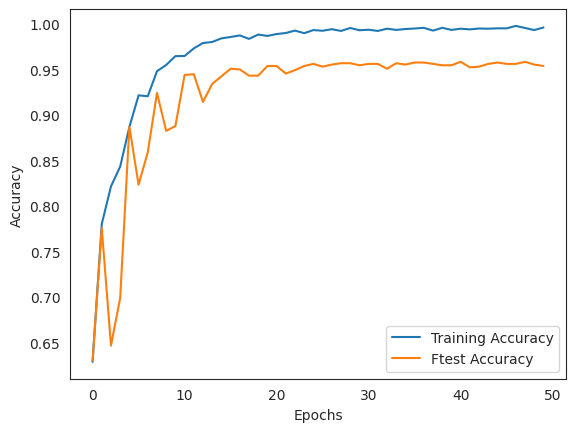

In [17]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_mobilenet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_mobilenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

In [19]:
# Evaluate the model on the validation set
val_loss, val_acc = model_mobilenet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predict class probabilities for the validation set
val_pred_probs = model_mobilenet.predict(val_generator)
# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_pred_probs, axis=1)
# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- MobileNet EVALUATION METRICS -----\n")
accuracy_mobilenet = accuracy_score(val_true_labels, val_pred_labels); print(f"Accuracy: {accuracy_mobilenet}")
precision_mobilenet = precision_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Precision: {precision_mobilenet}")
recall_mobilenet = recall_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Recall: {recall_mobilenet}")
f1_mobilenet = f1_score(val_true_labels, val_pred_labels, average='weighted'); print(f"F1 Score: {f1_mobilenet}")
bma_mobilenet = balanced_accuracy_score(val_true_labels, val_pred_labels); print(f"Balanced Accuracy: {bma_mobilenet}")
kappa_mobilenet = cohen_kappa_score(val_true_labels, val_pred_labels); print(f"Cohen's Kappa: {kappa_mobilenet}")

40/40 [==============================] - 41s 1s/step - loss: 0.5966 - accuracy: 0.8795
Validation Loss: 0.5965766906738281, Validation Accuracy: 0.8795275688171387
40/40 [==============================] - 36s 883ms/step

----- MobileNet EVALUATION METRICS -----

Accuracy: 0.8795275590551181
Precision: 0.8771125222858739
Recall: 0.8795275590551181
F1 Score: 0.8775230700878762
Balanced Accuracy: 0.7874622824442815
Cohen's Kappa: 0.7801962860400717


Classification Report:
               precision    recall  f1-score   support

         mel       0.90      0.86      0.88       498
         bcc       0.89      0.94      0.91       678
         scc       0.65      0.57      0.61        94

    accuracy                           0.88      1270
   macro avg       0.81      0.79      0.80      1270
weighted avg       0.88      0.88      0.88      1270



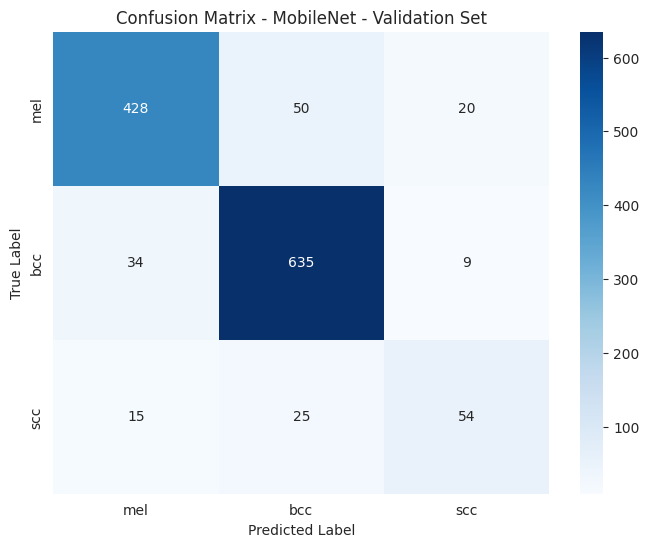

In [30]:
# Classification Report
class_report = classification_report(val_true_labels, val_pred_labels, target_names=['mel', 'bcc', 'scc'])
print("Classification Report:\n", class_report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['mel', 'bcc', 'scc'], yticklabels=['mel', 'bcc', 'scc'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - MobileNet - Validation Set')
plt.show()

# **- Pre-trained model (ResNet50)**

In [29]:
# Importing ResNet50 model from tf.keras.applications
from tensorflow.keras.applications.resnet50 import ResNet50

# Load pre-trained ResNet50 model with weights trained on ImageNet data
weight = "/kaggle/input/res-net50-weight/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"
resnet_model = ResNet50(weights= weight, include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in resnet_model.layers:
    layer.trainable = True

# Build the custom model using ResNet50 as a feature extractor
x = resnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)
model_resnet = Model(inputs=resnet_model.input, outputs=x)

# Compile the model
model_resnet.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

# Display the model architecture
model_resnet.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_4[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

    Callbacks

In [30]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_resnet_mc.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [33]:
# Train the model
history_resnet = model_resnet.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 3.0500 - accuracy: 0.5421
Epoch 1: val_accuracy improved from -inf to 0.32258, saving model to best_model_resnet_mc.hdf5
155/155 [==============================] - 149s 714ms/step - loss: 3.0500 - accuracy: 0.5421 - val_loss: 1.7794 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 1.1588 - accuracy: 0.6381
Epoch 2: val_accuracy improved from 0.32258 to 0.43548, saving model to best_model_resnet_mc.hdf5
155/155 [==============================] - 111s 714ms/step - loss: 1.1588 - accuracy: 0.6381 - val_loss: 1.2334 - val_accuracy: 0.4355 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.6393
Epoch 3: val_accuracy did not improve from 0.43548
155/155 [==============================] - 108s 697ms/step - loss: 0.9249 - accuracy: 0.6393 - val_loss: 1.1812 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 4/30
155/155 [====

In [23]:
# Train the model
history_resnet = model_resnet.fit(train_generator, epochs = 50, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/50
155/155 [==============================] - ETA: 0s - loss: 2.9401 - accuracy: 0.5468
Epoch 1: val_accuracy improved from -inf to 0.32258, saving model to best_model_resnet_mc.hdf5
155/155 [==============================] - 150s 721ms/step - loss: 2.9401 - accuracy: 0.5468 - val_loss: 2.9771 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 2/50
155/155 [==============================] - ETA: 0s - loss: 1.1309 - accuracy: 0.6121
Epoch 2: val_accuracy did not improve from 0.32258
155/155 [==============================] - 112s 721ms/step - loss: 1.1309 - accuracy: 0.6121 - val_loss: 1.2208 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 3/50
155/155 [==============================] - ETA: 0s - loss: 0.8274 - accuracy: 0.6681
Epoch 3: val_accuracy did not improve from 0.32258

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
155/155 [==============================] - 111s 717ms/step - loss: 0.8274 - accuracy: 0.6681 - val_loss: 1.1550 - val_accuracy: 0.3210 - lr: 0

In [31]:
# Train the model
history_resnet = model_resnet.fit(train_generator, epochs = 100, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/100
155/155 [==============================] - ETA: 0s - loss: 3.1709 - accuracy: 0.5425
Epoch 1: val_accuracy improved from -inf to 0.32258, saving model to best_model_resnet_mc.hdf5
155/155 [==============================] - 146s 720ms/step - loss: 3.1709 - accuracy: 0.5425 - val_loss: 1.8538 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - ETA: 0s - loss: 1.1947 - accuracy: 0.6187
Epoch 2: val_accuracy did not improve from 0.32258
155/155 [==============================] - 110s 710ms/step - loss: 1.1947 - accuracy: 0.6187 - val_loss: 1.3310 - val_accuracy: 0.3226 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - ETA: 0s - loss: 0.8685 - accuracy: 0.6605
Epoch 3: val_accuracy did not improve from 0.32258

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
155/155 [==============================] - 111s 712ms/step - loss: 0.8685 - accuracy: 0.6605 - val_loss: 1.2983 - val_accuracy: 0.3226 - lr

In [32]:
# Load the saved weights
model_resnet.load_weights('/kaggle/working/best_model_resnet_mc.hdf5')

39/39 [==============================] - 13s 341ms/step - loss: 0.2031 - accuracy: 0.9597
Ftest Loss: 0.20305070281028748, Ftest Accuracy: 0.9596773982048035


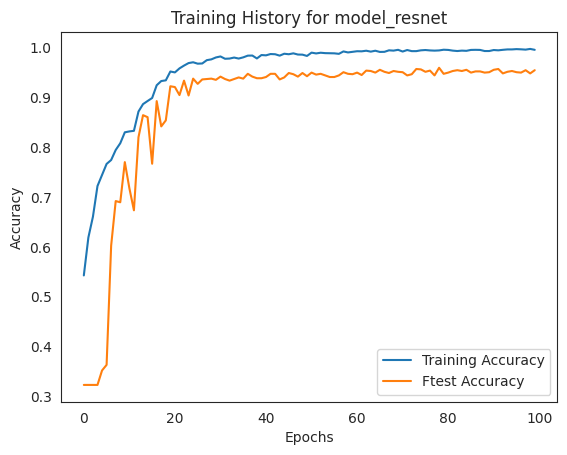

In [33]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_resnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_resnet')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

In [35]:
# Evaluate the model on the validation set
val_loss, val_acc = model_resnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predict class probabilities for the validation set
val_pred_probs = model_resnet.predict(val_generator)
# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_pred_probs, axis=1)
# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- ResNet50 EVALUATION METRICS -----\n")
accuracy_resnet = accuracy_score(val_true_labels, val_pred_labels); print(f"Accuracy: {accuracy_resnet}")
precision_resnet = precision_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Precision: {precision_resnet}")
recall_resnet = recall_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Recall: {recall_resnet}")
f1_resnet = f1_score(val_true_labels, val_pred_labels, average='weighted'); print(f"F1 Score: {f1_resnet}")
bma_resnet = balanced_accuracy_score(val_true_labels, val_pred_labels); print(f"Balanced Accuracy: {bma_resnet}")
kappa_resnet = cohen_kappa_score(val_true_labels, val_pred_labels); print(f"Cohen's Kappa: {kappa_resnet}")

40/40 [==============================] - 13s 325ms/step - loss: 0.5581 - accuracy: 0.8693
Validation Loss: 0.5580540299415588, Validation Accuracy: 0.869291365146637
40/40 [==============================] - 14s 330ms/step

----- ResNet50 EVALUATION METRICS -----

Accuracy: 0.8692913385826772
Precision: 0.8735789106418126
Recall: 0.8692913385826772
F1 Score: 0.8684662503072784
Balanced Accuracy: 0.7874245995467466
Cohen's Kappa: 0.7623974393652512


Classification Report:
               precision    recall  f1-score   support

         mel       0.94      0.83      0.88       498
         bcc       0.89      0.95      0.92       678
         scc       0.62      0.69      0.66        94

    accuracy                           0.88      1270
   macro avg       0.82      0.82      0.82      1270
weighted avg       0.89      0.88      0.88      1270



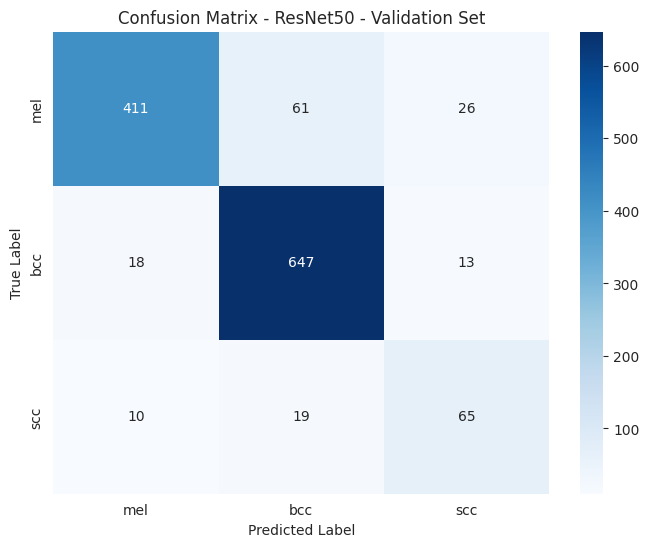

In [28]:
# Classification Report
class_report = classification_report(val_true_labels, val_pred_labels, target_names=['mel', 'bcc', 'scc'])
print("Classification Report:\n", class_report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['mel', 'bcc', 'scc'], yticklabels=['mel', 'bcc', 'scc'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - ResNet50 - Validation Set')
plt.show()

# **- Pre-trained model (InceptionResNetV2)**

In [12]:
# Importing InceptionResNetV2 model from tf.keras.applications
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

weight = "/kaggle/input/inception-resnetv2-weight/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5"
# Load pre-trained InceptionResNetV2 model with weights trained on ImageNet data
inceptionresnet_model = InceptionResNetV2(weights=weight, include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the pre-trained model
for layer in inceptionresnet_model.layers:
    layer.trainable = True

# Build the custom model using InceptionResNetV2 as a feature extractor
x = inceptionresnet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,kernel_regularizer='l2',activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(3, activation='softmax')(x)
model_inceptionresnet = Model(inputs=inceptionresnet_model.input, outputs=x)

# Compile the model
model_inceptionresnet.compile(loss="categorical_crossentropy", optimizer=Adam(lr=0.0001), metrics=["accuracy"])

# Display the model architecture
model_inceptionresnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization[0][0

    Callbacks

In [13]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001, verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_inceptionresnet_mc.hdf5',save_best_only=True, monitor='val_accuracy',verbose=1)

callback_list = [model_chkpt,lr_reduce]

In [43]:
# Train the model
history_inceptionresnet = model_inceptionresnet.fit(train_generator, epochs = 30, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 1.6930 - accuracy: 0.6494
Epoch 1: val_accuracy improved from -inf to 0.64274, saving model to best_model_inceptionresnet_mc.hdf5
155/155 [==============================] - 209s 765ms/step - loss: 1.6930 - accuracy: 0.6494 - val_loss: 1.6120 - val_accuracy: 0.6427 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 0.7617 - accuracy: 0.7391
Epoch 2: val_accuracy improved from 0.64274 to 0.67661, saving model to best_model_inceptionresnet_mc.hdf5
155/155 [==============================] - 114s 734ms/step - loss: 0.7617 - accuracy: 0.7391 - val_loss: 2.5209 - val_accuracy: 0.6766 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - ETA: 0s - loss: 0.6008 - accuracy: 0.7808
Epoch 3: val_accuracy did not improve from 0.67661
155/155 [==============================] - 111s 713ms/step - loss: 0.6008 - accuracy: 0.7808 - val_loss: 53.6897 - val_accuracy: 0.4637 - lr: 0.0010
Epoch

In [14]:
# Train the model
history_inceptionresnet = model_inceptionresnet.fit(train_generator, epochs = 100, validation_data = ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/100
155/155 [==============================] - ETA: 0s - loss: 1.8199 - accuracy: 0.6276
Epoch 1: val_accuracy improved from -inf to 0.51935, saving model to best_model_inceptionresnet_mc.hdf5
155/155 [==============================] - 245s 965ms/step - loss: 1.8199 - accuracy: 0.6276 - val_loss: 2.4115 - val_accuracy: 0.5194 - lr: 0.0010
Epoch 2/100
155/155 [==============================] - ETA: 0s - loss: 0.8103 - accuracy: 0.7339
Epoch 2: val_accuracy improved from 0.51935 to 0.62339, saving model to best_model_inceptionresnet_mc.hdf5
155/155 [==============================] - 118s 756ms/step - loss: 0.8103 - accuracy: 0.7339 - val_loss: 3.0038 - val_accuracy: 0.6234 - lr: 0.0010
Epoch 3/100
155/155 [==============================] - ETA: 0s - loss: 0.6218 - accuracy: 0.7821
Epoch 3: val_accuracy did not improve from 0.62339
155/155 [==============================] - 116s 744ms/step - loss: 0.6218 - accuracy: 0.7821 - val_loss: 1.3238 - val_accuracy: 0.5871 - lr: 0.0010
Epo

In [15]:
# Load the saved weights
model_inceptionresnet.load_weights('/kaggle/working/best_model_inceptionresnet_mc.hdf5')

39/39 [==============================] - 13s 340ms/step - loss: 0.1918 - accuracy: 0.9661
Ftest Loss: 0.1918034553527832, Ftest Accuracy: 0.9661290049552917


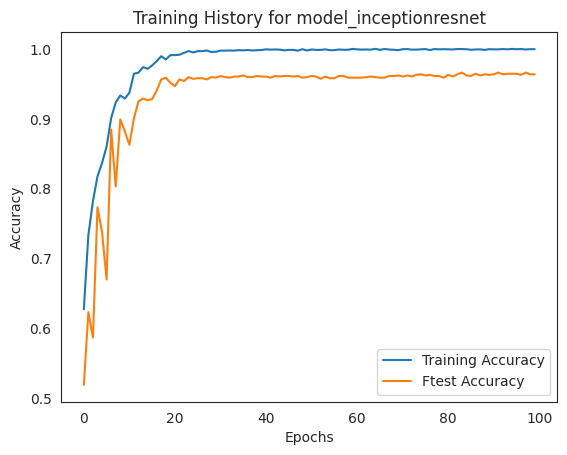

In [16]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_inceptionresnet.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(history_inceptionresnet.history['accuracy'], label='Training Accuracy')
plt.plot(history_inceptionresnet.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_inceptionresnet')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

In [18]:
# Evaluate the model on the validation set
val_loss, val_acc = model_inceptionresnet.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predict class probabilities for the validation set
val_pred_probs = model_inceptionresnet.predict(val_generator)
# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_pred_probs, axis=1)
# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- InceptionResnet EVALUATION METRICS -----\n")
accuracy_inceptionresnet = accuracy_score(val_true_labels, val_pred_labels); print(f"Accuracy: {accuracy_inceptionresnet}")
precision_inceptionresnet = precision_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Precision: {precision_inceptionresnet}")
recall_inceptionresnet = recall_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Recall: {recall_inceptionresnet}")
f1_inceptionresnet = f1_score(val_true_labels, val_pred_labels, average='weighted'); print(f"F1 Score: {f1_inceptionresnet}")
bma_inceptionresnet= balanced_accuracy_score(val_true_labels, val_pred_labels); print(f"Balanced Accuracy: {bma_inceptionresnet}")
kappa_inceptionresnet = cohen_kappa_score(val_true_labels, val_pred_labels); print(f"Cohen's Kappa: {kappa_inceptionresnet}")

40/40 [==============================] - 28s 707ms/step - loss: 0.4848 - accuracy: 0.9071
Validation Loss: 0.4848438799381256, Validation Accuracy: 0.9070866107940674
40/40 [==============================] - 16s 330ms/step

----- InceptionResnet EVALUATION METRICS -----

Accuracy: 0.9070866141732283
Precision: 0.9085783019390515
Recall: 0.9070866141732283
F1 Score: 0.905836206606858
Balanced Accuracy: 0.8409678379620282
Cohen's Kappa: 0.8301138167142792


Classification Report:
               precision    recall  f1-score   support

         mel       0.96      0.86      0.90       498
         bcc       0.89      0.97      0.93       678
         scc       0.76      0.69      0.73        94

    accuracy                           0.91      1270
   macro avg       0.87      0.84      0.85      1270
weighted avg       0.91      0.91      0.91      1270



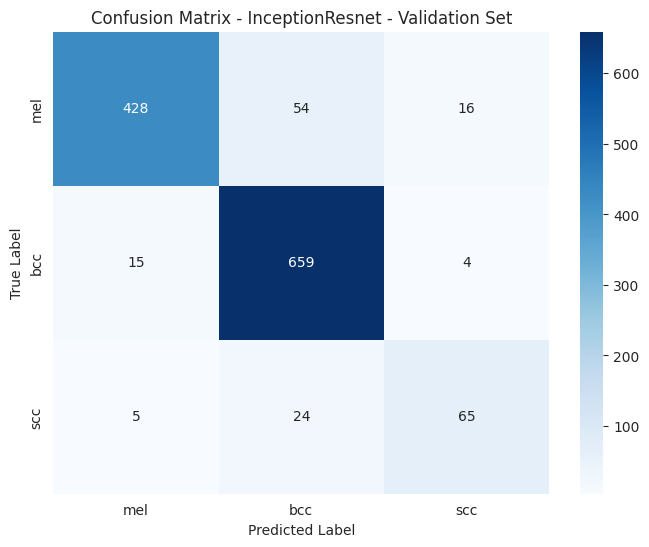

In [19]:
# Classification Report
class_report = classification_report(val_true_labels, val_pred_labels, target_names=['mel', 'bcc', 'scc'])
print("Classification Report:\n", class_report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(val_true_labels, val_pred_labels)

# Display confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['mel', 'bcc', 'scc'], yticklabels=['mel', 'bcc', 'scc'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - InceptionResnet - Validation Set')
plt.show()

# **- Pre-trained model (EfficientNet V2 B0)**

In [49]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

# Function to get any model/preprocessor from tensorflow hub
def get_tfhub_model(model_link, model_name, model_trainable=False):
    return hub.KerasLayer(model_link, trainable=model_trainable, name=model_name)

# Get EfficientNet V2 B0 from TensorFlow Hub
efficientnet_v2_url = 'https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2'
model_name = 'efficientnet_v2_b0'
set_trainable=False # Set trainable to False for inference-only 

efficientnet_v2_b0 = get_tfhub_model(efficientnet_v2_url, model_name, model_trainable=set_trainable)

# Define the EfficientNet V2 B0 model
def efficientnet_v2_model():
    initializer = tf.keras.initializers.GlorotNormal()
    
    efficientnet_v2_sequential = Sequential([
        layers.Input(shape=(224, 224, 3), dtype=tf.float32, name='input_image'),
        efficientnet_v2_b0,
        layers.Dropout(0.2),
        layers.Dense(128, activation='relu', kernel_initializer=initializer),
        layers.Dense(3, activation='softmax', kernel_initializer=initializer)
    ], name='efficientnet_v2_sequential_model')
    
    return efficientnet_v2_sequential

# Generate the EfficientNet V2 B0 model
model_efficientnet_v2 = efficientnet_v2_model()

# Display the model summary
model_efficientnet_v2.summary()

Model: "efficientnet_v2_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet_v2_b0 (KerasL  (None, 1280)              5919312   
 ayer)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_8 (Dense)             (None, 128)               163968    
                                                                 
 dense_9 (Dense)             (None, 3)                 387       
                                                                 
Total params: 6083667 (23.21 MB)
Trainable params: 164355 (642.01 KB)
Non-trainable params: 5919312 (22.58 MB)
_________________________________________________________________


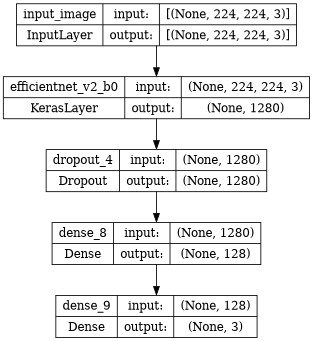

In [50]:
# Visualize the model
plot_model(model_efficientnet_v2, dpi=60, show_shapes=True)

In [51]:
# Compile the model
model_efficientnet_v2.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

    Callbacks

In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=2, verbose=1)
model_chkpt = ModelCheckpoint('best_model_efficientnet_v2_mc.hdf5', save_best_only=True, monitor='val_accuracy', verbose=1)

callback_list = [model_chkpt, lr_reduce]

In [53]:
# Train the model
efficientnet_v2_history = model_efficientnet_v2.fit(train_generator, epochs=30, validation_data=ftest_generator, class_weight=class_weights_dict, callbacks=callback_list)

Epoch 1/30
155/155 [==============================] - ETA: 0s - loss: 0.8825 - accuracy: 0.6379
Epoch 1: val_accuracy improved from -inf to 0.72661, saving model to best_model_efficientnet_v2_mc.hdf5
155/155 [==============================] - 119s 715ms/step - loss: 0.8825 - accuracy: 0.6379 - val_loss: 0.6458 - val_accuracy: 0.7266 - lr: 0.0010
Epoch 2/30
155/155 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.7371
Epoch 2: val_accuracy improved from 0.72661 to 0.77984, saving model to best_model_efficientnet_v2_mc.hdf5
155/155 [==============================] - 106s 687ms/step - loss: 0.6325 - accuracy: 0.7371 - val_loss: 0.5554 - val_accuracy: 0.7798 - lr: 0.0010
Epoch 3/30
155/155 [==============================] - ETA: 0s - loss: 0.5927 - accuracy: 0.7534
Epoch 3: val_accuracy did not improve from 0.77984
155/155 [==============================] - 106s 686ms/step - loss: 0.5927 - accuracy: 0.7534 - val_loss: 0.5593 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 

In [54]:
# Load the saved weights
model_efficientnet_v2.load_weights('/kaggle/working/best_model_efficientnet_v2_mc.hdf5')

39/39 [==============================] - 12s 314ms/step - loss: 0.2945 - accuracy: 0.8879
Ftest Loss: 0.2944648563861847, Ftest Accuracy: 0.8879032135009766


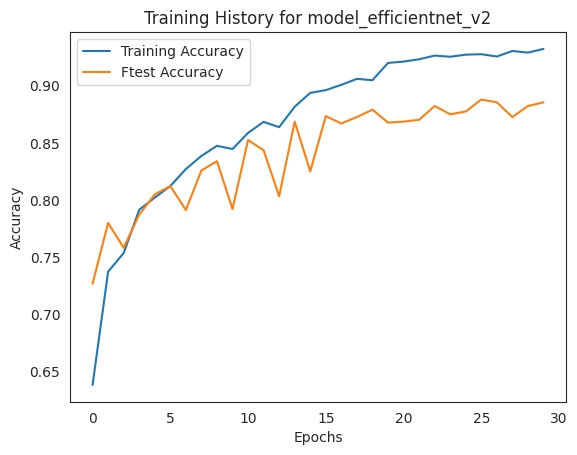

In [55]:
# Evaluate the model on the fake_test set
ftest_loss, ftest_acc = model_efficientnet_v2.evaluate(ftest_generator)
print(f'Ftest Loss: {ftest_loss}, Ftest Accuracy: {ftest_acc}')

# Plot training history
plt.plot(efficientnet_v2_history.history['accuracy'], label='Training Accuracy')
plt.plot(efficientnet_v2_history.history['val_accuracy'], label='Ftest Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training History for model_efficientnet_v2')
plt.show()

**-----: LEVERAGING THE TRAINED MODEL ON THE VALIDATION DATASET**

**Leveraging trained model for feature extraction and classification**

In [57]:
# Evaluate the model on the validation set
val_loss, val_acc = model_efficientnet_v2.evaluate(val_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

# Predict class probabilities for the validation set
val_pred_probs = model_efficientnet_v2.predict(val_generator)
# Convert predicted probabilities to class labels
val_pred_labels = np.argmax(val_pred_probs, axis=1)
# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- EfficientNet_v2 EVALUATION METRICS -----\n")
accuracy_efficientnet_v2 = accuracy_score(val_true_labels, val_pred_labels); print(f"Accuracy: {accuracy_efficientnet_v2}")
precision_efficientnet_v2 = precision_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Precision: {precision_efficientnet_v2}")
recall_efficientnet_v2 = recall_score(val_true_labels, val_pred_labels, average='weighted'); print(f"Recall: {recall_efficientnet_v2}")
f1_efficientnet_v2 = f1_score(val_true_labels, val_pred_labels, average='weighted'); print(f"F1 Score: {f1_efficientnet_v2}")
bma_efficientnet_v2= balanced_accuracy_score(val_true_labels, val_pred_labels); print(f"Balanced Accuracy: {bma_efficientnet_v2}")
kappa_efficientnet_v2 = cohen_kappa_score(val_true_labels, val_pred_labels); print(f"Cohen's Kappa: {kappa_efficientnet_v2}")

40/40 [==============================] - 14s 339ms/step - loss: 0.4559 - accuracy: 0.8331
Validation Loss: 0.45592114329338074, Validation Accuracy: 0.8330708742141724
40/40 [==============================] - 13s 319ms/step

----- EfficientNet_v2 EVALUATION METRICS -----

Accuracy: 0.8330708661417323
Precision: 0.8539834574006392
Recall: 0.8330708661417323
F1 Score: 0.8363027272825055
Balanced Accuracy: 0.7859019080149129
Cohen's Kappa: 0.7029882095453261


# **- ENSEMBLE OF MOBILENET + INCEPTIONRESNETV2 (-+) RESNET50**

In [13]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_mobilenet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_mobilenet_mc.hdf5')
model_inceptionresnet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_inceptionresnet_mc.hdf5')

# Predictions on the validation set for both models
val_predictions_mobilenet = model_mobilenet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = 0.5 * (val_predictions_mobilenet + val_predictions_inceptionresnet)
ensemble_pred_classes = np.argmax(ensemble_predictions , axis=1)

# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET EVALUATION METRICS -----\n")
accuracy_ensemble = accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Accuracy: {accuracy_ensemble}")
precision_ensemble = precision_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Precision: {precision_ensemble}")
recall_ensemble = recall_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Recall: {recall_ensemble}")
f1_ensemble = f1_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"F1 Score: {f1_ensemble}")
bma_ensemble = balanced_accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Balanced Accuracy: {bma_ensemble}")
kappa_ensemble = cohen_kappa_score(val_true_labels, ensemble_pred_classes); print(f"Cohen's Kappa: {kappa_ensemble}")

40/40 [==============================] - 114s 3s/step

----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET EVALUATION METRICS -----

Accuracy: 0.9181102362204724
Precision: 0.917539228856076
Recall: 0.9181102362204724
F1 Score: 0.9168585214884796
Balanced Accuracy: 0.8478173032303696
Cohen's Kappa: 0.8506436525813952


In [18]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_mobilenet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_mobilenet_mc.hdf5')
model_inceptionresnet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_inceptionresnet_mc.hdf5')

# Predictions on the validation set for both models
val_predictions_mobilenet = model_mobilenet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)

weight_mobilenet = 0.4
weight_inceptionresnet = 0.6

# Combine predictions (you can use averaging or another strategy)
# ensemble_predictions = 0.5 * (val_predictions_mobilenet + val_predictions_inceptionresnet)
ensemble_predictions = (weight_mobilenet * val_predictions_mobilenet) + (weight_inceptionresnet * val_predictions_inceptionresnet)
ensemble_pred_classes = np.argmax(ensemble_predictions , axis=1)

# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET EVALUATION METRICS -----\n")
accuracy_ensemble = accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Accuracy: {accuracy_ensemble}")
precision_ensemble = precision_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Precision: {precision_ensemble}")
recall_ensemble = recall_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Recall: {recall_ensemble}")
f1_ensemble = f1_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"F1 Score: {f1_ensemble}")
bma_ensemble = balanced_accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Balanced Accuracy: {bma_ensemble}")
kappa_ensemble = cohen_kappa_score(val_true_labels, ensemble_pred_classes); print(f"Cohen's Kappa: {kappa_ensemble}")

40/40 [==============================] - 119s 3s/step

----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET EVALUATION METRICS -----

Accuracy: 0.9188976377952756
Precision: 0.9191568940741043
Recall: 0.9188976377952756
F1 Score: 0.9175703672902648
Balanced Accuracy: 0.8475981374818297
Cohen's Kappa: 0.8517780738968055


In [13]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_mobilenet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_mobilenet_mc.hdf5')
model_inceptionresnet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_inceptionresnet_mc.hdf5')
model_resnet = load_model("/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_resnet_mc.hdf5")

# Predictions on the validation set for both models
val_predictions_mobilenet = model_mobilenet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)
val_predictions_resnet = model_resnet.predict(val_generator)

weight_mobilenet = 0.3; weight_inceptionresnet = 0.6; weight_resnet = 0.1

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = (weight_mobilenet * val_predictions_mobilenet) + (weight_inceptionresnet * val_predictions_inceptionresnet) + (weight_resnet * val_predictions_resnet)
ensemble_pred_classes = np.argmax(ensemble_predictions , axis=1)

# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET+RESNET50 EVALUATION METRICS -----\n")
accuracy_ensemble = accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Accuracy: {accuracy_ensemble}")
precision_ensemble = precision_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Precision: {precision_ensemble}")
recall_ensemble = recall_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Recall: {recall_ensemble}")
f1_ensemble = f1_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"F1 Score: {f1_ensemble}")
bma_ensemble = balanced_accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Balanced Accuracy: {bma_ensemble}")
kappa_ensemble = cohen_kappa_score(val_true_labels, ensemble_pred_classes); print(f"Cohen's Kappa: {kappa_ensemble}")

40/40 [==============================] - 123s 3s/step

----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET EVALUATION METRICS -----

Accuracy: 0.9196850393700787
Precision: 0.9199588436647671
Recall: 0.9196850393700787
F1 Score: 0.9185372308920179
Balanced Accuracy: 0.851499640689161
Cohen's Kappa: 0.8533739609178332


In [13]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_mobilenet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_mobilenet_mc.hdf5')
model_inceptionresnet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_inceptionresnet_mc.hdf5')
model_resnet = load_model("/kaggle/input/best-model-resnet-mc-e50/best_model_resnet_mc_E50.hdf5")

# Predictions on the validation set for both models
val_predictions_mobilenet = model_mobilenet.predict(val_generator)
val_predictions_inceptionresnet = model_inceptionresnet.predict(val_generator)
val_predictions_resnet = model_resnet.predict(val_generator)

# weight_mobilenet = 0.2; weight_inceptionresnet = 0.6; weight_resnet = 0.2

# # Combine predictions (you can use averaging or another strategy)
# ensemble_predictions = (weight_mobilenet * val_predictions_mobilenet) + (weight_inceptionresnet * val_predictions_inceptionresnet) + (weight_resnet * val_predictions_resnet)
# ensemble_pred_classes = np.argmax(ensemble_predictions , axis=1)

# # True labels from the validation set
# val_true_labels = val_generator.classes

# # Calculate evaluation metrics on the validation dataset
# print("\n----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET+RESNET50 EVALUATION METRICS -----\n")
# accuracy_ensemble = accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Accuracy: {accuracy_ensemble}")
# precision_ensemble = precision_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Precision: {precision_ensemble}")
# recall_ensemble = recall_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Recall: {recall_ensemble}")
# f1_ensemble = f1_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"F1 Score: {f1_ensemble}")
# bma_ensemble = balanced_accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Balanced Accuracy: {bma_ensemble}")
# kappa_ensemble = cohen_kappa_score(val_true_labels, ensemble_pred_classes); print(f"Cohen's Kappa: {kappa_ensemble}")

40/40 [==============================] - 17s 364ms/step

----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET+RESNET50 EVALUATION METRICS -----

Accuracy: 0.9204724409448819
Precision: 0.9205324746243057
Recall: 0.9204724409448819
F1 Score: 0.9193023746543425
Balanced Accuracy: 0.8523466866902746
Cohen's Kappa: 0.8548042398475031


In [23]:
weight_mobilenet = 0.2; weight_inceptionresnet = 0.6; weight_resnet = 0.2

# Combine predictions (you can use averaging or another strategy)
ensemble_predictions = (weight_mobilenet * val_predictions_mobilenet) + (weight_inceptionresnet * val_predictions_inceptionresnet) + (weight_resnet * val_predictions_resnet)
# ensemble_predictions = 0.5*(val_predictions_mobilenet + val_predictions_inceptionresnet + val_predictions_resnet)
ensemble_pred_classes = np.argmax(ensemble_predictions , axis=1)

# True labels from the validation set
val_true_labels = val_generator.classes

# Calculate evaluation metrics on the validation dataset
print("\n----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET+RESNET50 EVALUATION METRICS -----\n")
accuracy_ensemble = accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Accuracy: {accuracy_ensemble}")
precision_ensemble = precision_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Precision: {precision_ensemble}")
recall_ensemble = recall_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"Recall: {recall_ensemble}")
f1_ensemble = f1_score(val_true_labels, ensemble_pred_classes, average='weighted'); print(f"F1 Score: {f1_ensemble}")
bma_ensemble = balanced_accuracy_score(val_true_labels, ensemble_pred_classes); print(f"Balanced Accuracy: {bma_ensemble}")
kappa_ensemble = cohen_kappa_score(val_true_labels, ensemble_pred_classes); print(f"Cohen's Kappa: {kappa_ensemble}")


----- ENSEMBLE OF MOBILENET+INCEPTIONRESNET+RESNET50 EVALUATION METRICS -----

Accuracy: 0.9220472440944882
Precision: 0.9222783873844239
Recall: 0.9220472440944882
F1 Score: 0.9209578468834404
Balanced Accuracy: 0.8565621300238927
Cohen's Kappa: 0.8576794034148794


# **(D): LEVERAGING THE MODEL BUILT ON THE TEST DATASET**

**EXPLORATORY DATA ANALYSIS**

In [24]:
import tarfile
test_archive_path = "/kaggle/input/challenge-2-test/test.tgz" # path to the test archive
extracted_dir_path = "/kaggle/working/test_images"            # directory to extract images to

# Create the directory if it doesn't exist
os.makedirs(extracted_dir_path, exist_ok = True)

# Extract the images from the archive
with tarfile.open(test_archive_path, "r:gz") as tar:
    tar.extractall(path = extracted_dir_path)

# List image names in the directory
test_img_name = os.listdir(os.path.join(extracted_dir_path, "testX"))

# Sort the image names in ascending order
test_img_name.sort()

# Create a list of dictionaries for each image
test_data = []
for img_name in test_img_name:
    test_img_file = os.path.join(extracted_dir_path, "testX", img_name)
    test_data.append({"test_img_name": img_name, "test_img_file": test_img_file})

# Create a DataFrame from the list of dictionaries
test_df = pd.DataFrame(test_data)
test_df.head()

,test_img_name,test_img_file
0,xxx00001.jpg,/kaggle/working/test_images/testX/xxx00001.jpg
1,xxx00002.jpg,/kaggle/working/test_images/testX/xxx00002.jpg
2,xxx00003.jpg,/kaggle/working/test_images/testX/xxx00003.jpg
3,xxx00004.jpg,/kaggle/working/test_images/testX/xxx00004.jpg
4,xxx00005.jpg,/kaggle/working/test_images/testX/xxx00005.jpg


**LEVERAGING THE TRAINED MODEL ON THE TEST DATASET**

**Data Preprocessing**

In [25]:
test_datagen = ImageDataGenerator(rescale = 1./255)

# Evaluate the model on the test set
test_generator = test_datagen.flow_from_dataframe(dataframe = test_df, x_col = "test_img_file",
                                                target_size = (224, 224), batch_size = batch_size, class_mode = None, shuffle=False)

Found 2121 validated image filenames.


**Leveraging trained model for feature extraction and classification**

In [14]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_inceptionresnet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_inceptionresnet_mc.hdf5')

# Predictions on the test set
test_predictions_inceptionresnet = model_inceptionresnet.predict(test_generator)

# Get the predicted class labels based on the highest probability
predicted_labels = np.argmax(test_predictions_inceptionresnet, axis=1)

67/67 [==============================] - 31s 364ms/step


In [26]:
from tensorflow.keras.models import load_model

# Load pre-trained models
model_mobilenet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_mobilenet_mc.hdf5')
model_inceptionresnet = load_model('/kaggle/input/multiclass-best-models/Multiclass_Best_Models(2700_2000_1500)/best_model_inceptionresnet_mc.hdf5')
model_resnet = load_model("/kaggle/input/best-model-resnet-mc-e50/best_model_resnet_mc_E50.hdf5")

# Predictions on the validation set for both models
test_predictions_mobilenet = model_mobilenet.predict(test_generator)
test_predictions_inceptionresnet = model_inceptionresnet.predict(test_generator)
test_predictions_resnet = model_resnet.predict(test_generator)

# Combine predictions (Get the predicted class labels based on the highest probability)
weight_mobilenet = 0.2; weight_inceptionresnet = 0.6; weight_resnet = 0.2
ensemble_predictions = (weight_mobilenet * test_predictions_mobilenet) + (weight_inceptionresnet * test_predictions_inceptionresnet) + (weight_resnet * test_predictions_resnet)
predicted_labels = np.argmax(ensemble_predictions , axis=1)

67/67 [==============================] - 22s 314ms/step


In [27]:
# Create a DataFrame for the test results
test_results = pd.DataFrame({"image_name": test_df["test_img_name"], "predicted_label": predicted_labels})
test_results.head()

,image_name,predicted_label
0,xxx00001.jpg,2
1,xxx00002.jpg,0
2,xxx00003.jpg,0
3,xxx00004.jpg,1
4,xxx00005.jpg,1


In [28]:
# Save the test results to a CSV file
test_results.to_csv("/kaggle/working/multiclass_test_results_DL.csv", index=False)